# Sheet 2

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

## 1 Kernel Density Estimation
(a)

In [4]:
def biweight(x, mu, w):
    """Biweight kernel at mean mu, with bandwidth w, evaluated at x."""
    #TODO: implement the quartic (biweight) kernel

    u = (x - mu) / w
    if abs(u) < 1:
        return (15 / 16) * (1 - u**2)**2 / w
    else:
        return 0


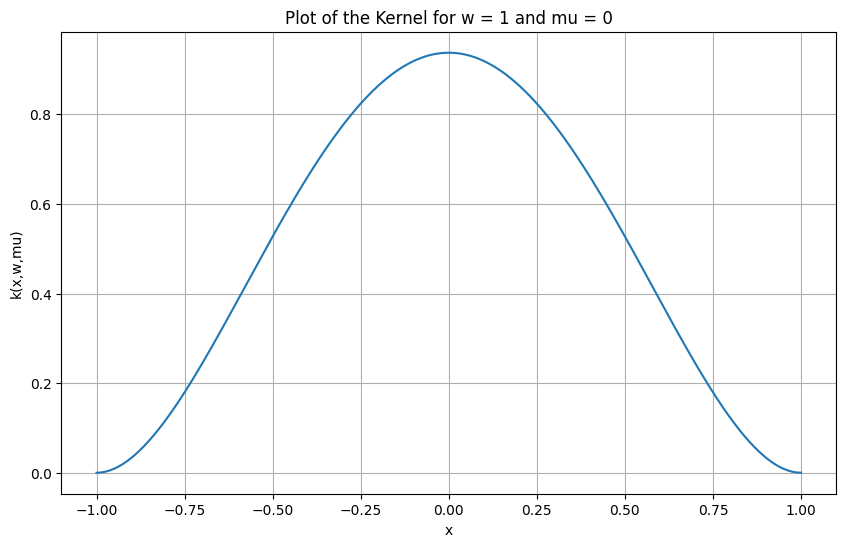

In [5]:
# TODO plot the kernel

interval = np.linspace(-1, 1, 1000)
kernel = [biweight(x, 0, 1) for x in interval]

plt.figure(figsize=(10, 6))
plt.plot(interval, kernel, linestyle="-")
plt.title("Plot of the Kernel for w = 1 and mu = 0")
plt.xlabel("x")
plt.ylabel("k(x,w,mu)")
plt.grid(True)
plt.show()

(b)

In [6]:
# load the data
data = np.load("data/samples.npy")
data50 = data[:50]
print(f'{data.shape=}, {data50.shape=}')

data.shape=(10000,), data50.shape=(50,)


In [7]:
def kde(x, obs, w=1):
    # TODO: implement the KDE with the biweight kernel

    density = np.sum([biweight(x, mu, w) for mu in obs]) / len(obs)
    return density

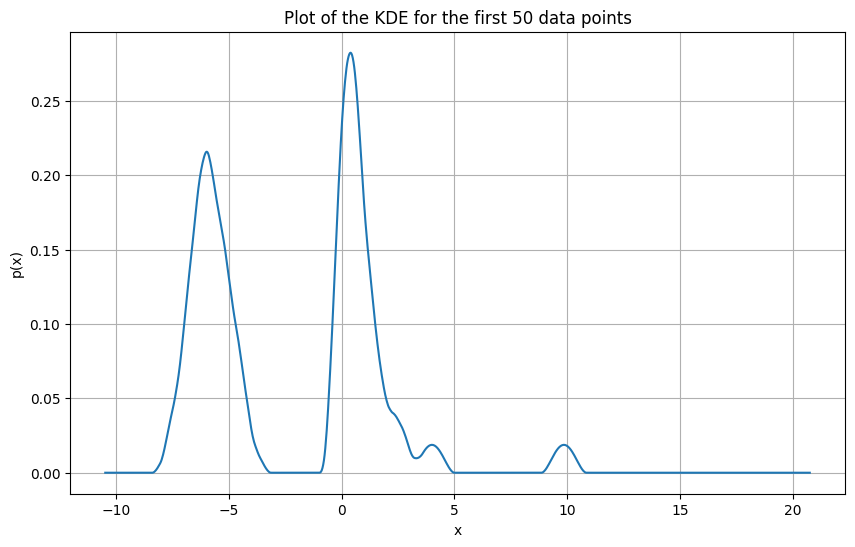

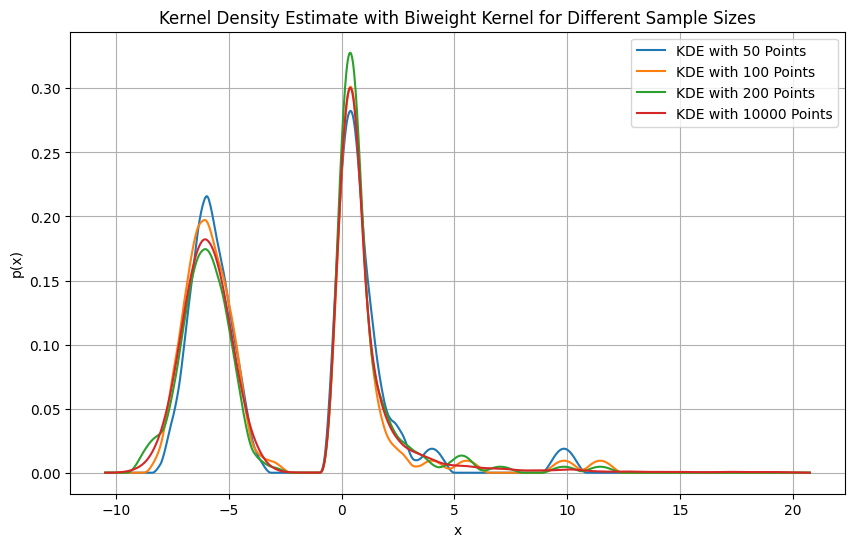

In [8]:
# TODO: compute and plot the kde on the first 50 data points

x_values = np.linspace(min(data) - 1, max(data) + 1, 1000)

kde_values_50 = [kde(x, data50, w=1) for x in x_values]

plt.figure(figsize=(10, 6))
plt.plot(x_values, kde_values_50, linestyle="-")
plt.title("Plot of the KDE for the first 50 data points")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.grid(True)
plt.show()


# TODO: explore what happens when you increase the number of points


plt.figure(figsize=(10, 6))
bandwidth = 1 

for n in [50, 100, 200, len(data)]:
    data_n = data[:n]
    kde_values_n = [kde(x, data_n, w=bandwidth) for x in x_values]
    plt.plot(x_values, kde_values_n, label=f"KDE with {n} Points", linestyle="-")


plt.title("Kernel Density Estimate with Biweight Kernel for Different Sample Sizes")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.grid(True)
plt.legend()
plt.show()




## 3 Mean-Shift
(b)

In [11]:
# TODO: implement the update to the local mean

def mean_shift_step(x, xt, r=1):
    """
    A single step of mean shift, moving every point in xt to the local mean of points in x within a radius of r.
    
    Parameters
    ----------
    x : np.ndarray
        Array of points underlying the KDE, shape (N1,)
    xt : np.ndarray
        Current state of the mean shift algorithm, shape (N2,)
    r : float, optional
        Radius defining the neighborhood for the KDE, by default 1.
        
    Returns
    -------
    np.ndarray
        The points after the mean-shift step.
    """
    # Ensure x and xt have the same dimensionality
    assert xt.ndim == 1 and x.ndim == 1, "This function only supports 1D data for this exercise."
    
    # Calculate pairwise distances between each point in xt and all points in x
    dists = np.abs(x[:, np.newaxis] - xt)  # Shape (N1, N2)
    
    # Initialize an array for local means
    local_means = np.zeros_like(xt)
    
    # For each point in xt, compute the local mean of neighbors within radius r
    for j in range(len(xt)):
        # Find neighbors within radius r
        neighbors = x[dists[:, j] < r]
        
        # Calculate the mean of neighbors or retain point if no neighbors are within radius
        if len(neighbors) > 0:
            local_means[j] = np.mean(neighbors)
        else:
            local_means[j] = xt[j]  # No shift if no neighbors within radius
    
    return local_means

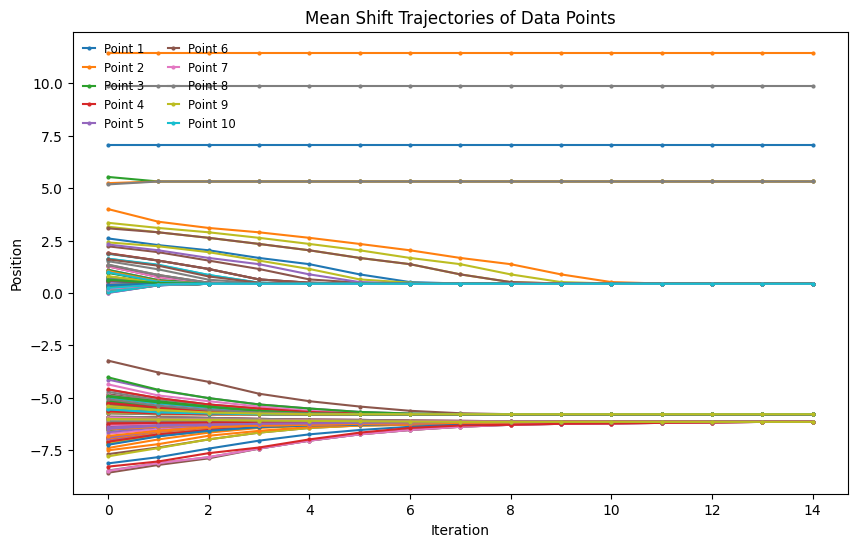

In [12]:
# load the data
data = np.load("data/samples.npy")
x = data[:200]  # use e.g. the first 200 points
xt = x

trajectories = [xt]
max_steps = 100
for step in range(max_steps):
    
    # TODO: update xt with your mean shift step

    xt = mean_shift_step(x, xt, r=1)  
    trajectories.append(xt.copy())
    

    if np.allclose(trajectories[-1], trajectories[-2], atol=1e-3):
        break

trajectories = np.stack(trajectories)
n_steps = len(trajectories) - 1


# TODO: plot the trajectories

plt.figure(figsize=(10, 6))
for i in range(xt.shape[0]):
    plt.plot(trajectories[:, i], label=f'Point {i+1}' if i < 10 else "", marker='o', markersize=2)
plt.xlabel('Iteration')
plt.ylabel('Position')
plt.title('Mean Shift Trajectories of Data Points')
plt.legend(loc="upper left", ncol=2, fontsize='small', handlelength=1, frameon=False)
plt.show()


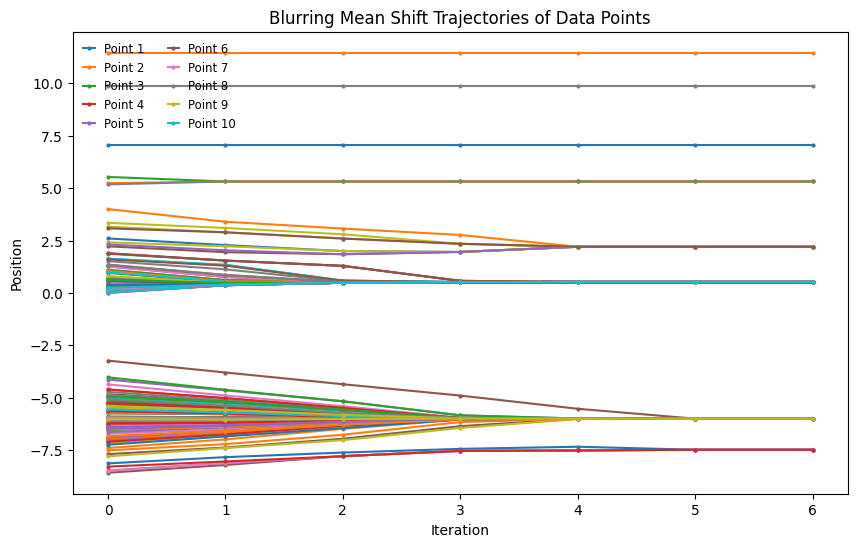

In [13]:
# TODO: repeat the above for "blurring" mean shift

def blurring_mean_shift_step(xt, r=1):
    """
    A single step of blurring mean shift, where every point in xt is moved to the local mean 
    of other points in xt within a radius of r.
    
    Parameters
    ----------
    xt : np.ndarray
        Current state of the mean shift algorithm, shape (N,)
    r : float, optional
        Radius defining the neighborhood for the KDE, by default 1.
        
    Returns
    -------
    np.ndarray
        The points after the blurring mean-shift step.
    """
    # Calculate pairwise distances between points in xt
    dists = np.abs(xt[:, np.newaxis] - xt)  # Shape (N, N)
    
    # Initialize an array for local means
    local_means = np.zeros_like(xt)
    
    # For each point in xt, compute the local mean of neighbors within radius r
    for j in range(len(xt)):
        # Find neighbors within radius r in the current state of xt
        neighbors = xt[dists[:, j] < r]
        
        # Calculate the mean of neighbors or retain point if no neighbors are within radius
        if len(neighbors) > 0:
            local_means[j] = np.mean(neighbors)
        else:
            local_means[j] = xt[j]  # No shift if no neighbors within radius
    
    return local_means

# Run blurring mean shift
xt_blur = x.copy()
trajectories_blur = [xt_blur.copy()]
max_steps = 100

for step in range(max_steps):
    xt_blur = blurring_mean_shift_step(xt_blur, r=1)  # Update xt with blurring mean shift step
    trajectories_blur.append(xt_blur.copy())
    
    # Check for convergence
    if np.allclose(trajectories_blur[-1], trajectories_blur[-2], atol=1e-3):
        break

# Convert list of trajectories to numpy array for easy indexing
trajectories_blur = np.stack(trajectories_blur)
n_steps_blur = len(trajectories_blur) - 1

# Plotting the blurring mean shift trajectories
plt.figure(figsize=(10, 6))
for i in range(xt_blur.shape[0]):
    plt.plot(trajectories_blur[:, i], label=f'Point {i+1}' if i < 10 else "", marker='o', markersize=2)
plt.xlabel('Iteration')
plt.ylabel('Position')
plt.title('Blurring Mean Shift Trajectories of Data Points')
plt.legend(loc="upper left", ncol=2, fontsize='small', handlelength=1, frameon=False)
plt.show()
